In [1]:
!hostname

n20.clstr


In [2]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import re
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

In [3]:
path='/import/c1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ROS_Tlevels/'
pattern=f'ROS_Tl*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

start_year = '1950-1951'
data = data.sel(season=data.season >= start_year)


In [4]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)
lat=data['XLAT']
lon=data['XLONG']

seasons=data['season']

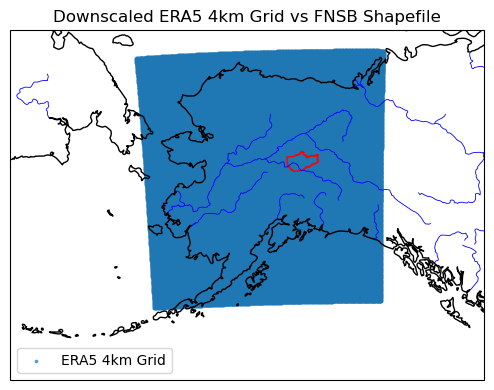

In [5]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
ax.scatter(lon.values, lat.values, s=3, alpha=0.6, transform=ccrs.PlateCarree(), label='ERA5 4km Grid' )
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, transform=ccrs.PlateCarree())

rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', facecolor='none',edgecolor='blue')
ax.add_feature(rivers, linewidth=0.6, zorder=3)
ax.coastlines()
ax.set_aspect('equal') 
ax.set_title("Downscaled ERA5 4km Grid vs FNSB Shapefile")
ax.set_extent([-179, -130, 51, 72], crs=ccrs.PlateCarree())
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [6]:
average_ROS_tally=np.nanmean(data['ros_counts'],axis=0)
average_ROS_daily=np.nanmean(data['ros_days_count'],axis=0)

TOTAL DATA SET
-

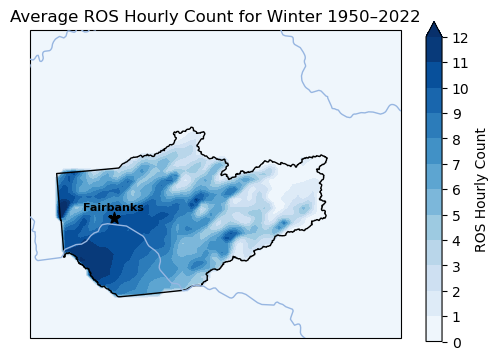

In [7]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 13, 1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, average_ROS_tally, levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Average ROS Hourly Count for Winter 1950–2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [8]:
season_strings = seasons.values.astype(str)
season_start_years = np.array([int(season.split('-')[0]) for season in season_strings])
mask = (season_start_years >= 1991) & (season_start_years <= 2020)
average_ROS_tally_1991_2020 = np.nanmean(data['ros_counts'][mask], axis=0)
average_ROS_daily_1991_2020 = np.nanmean(data['ros_days_count'][mask], axis=0)

mask2 = (season_start_years >= 1989) & (season_start_years <= 2020)
average_ROS_tally_1989_2020 = np.nanmean(data['ros_counts'][mask2], axis=0)
average_ROS_daily_1989_2020 = np.nanmean(data['ros_days_count'][mask2], axis=0)

Mathcing the satellite ABOVE Dataset time period...

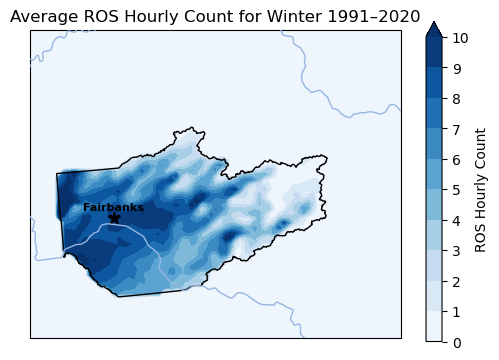

In [9]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 11, 1)
#levels = np.linspace(0, 10, 100)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, average_ROS_tally_1991_2020, levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')
ax.set_title("Average ROS Hourly Count for Winter 1991–2020")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Most recent 30 years (1993-2022)
-

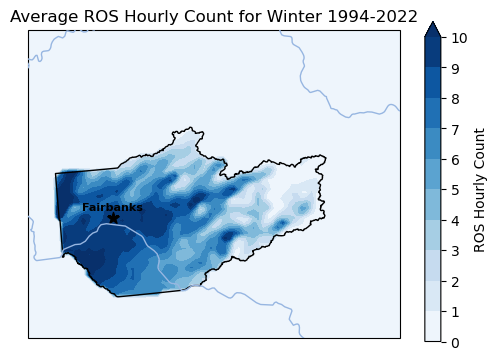

In [10]:
ros_trend_data = data['ros_tally'].values  
last_10_years = 30
seasons_last_10 = seasons[-last_10_years:]  
ros_trend_last_10 = ros_trend_data[-last_10_years:, :, :] 

ros_days=data['ros_days_count'].values
seasons_last_10 = seasons[-last_10_years:]  
ros_days_trend_last_10=ros_days[-last_10_years:,:,:]
ros_firs_10_mean=np.mean(ros_trend_last_10,axis=0)

AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 11, 1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, np.mean(ros_trend_last_10,axis=0) , levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')
ax.set_title("Average ROS Hourly Count for Winter 1994-2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.show()

First 30 years (1950-1981)
-

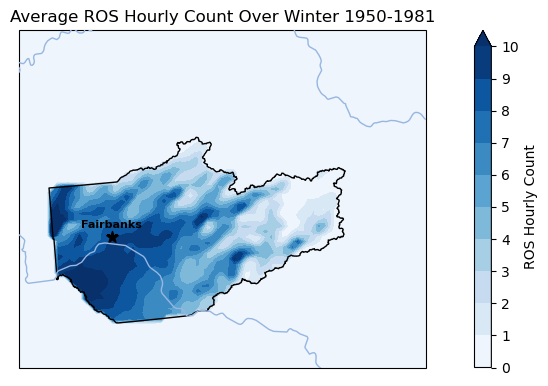

In [11]:
#FIRST 30 YEARS IN DATASET
#1950 -1981
ros_trend_data = data['ros_tally'].values  
last_10_years = 30
seasons_last_10 = seasons[last_10_years:]  
ros_trend_last_10 = ros_trend_data[last_10_years:, :, :]  
ros_last_10_mean=np.mean(ros_trend_last_10,axis=0)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(0, 11,1)
cmap = plt.get_cmap('Blues')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_last_10_mean, levels=levels, cmap=cmap, extend='max', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average ROS Hourly Count Over Winter 1950-1981")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

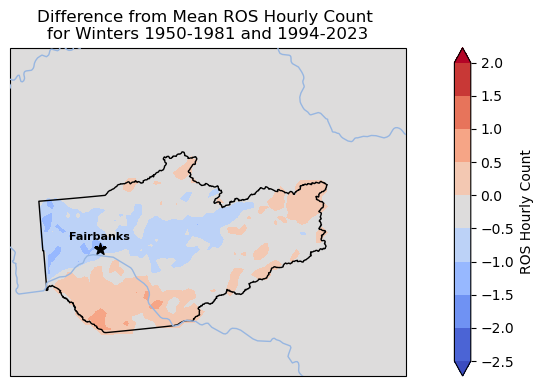

In [12]:
diff= ros_last_10_mean-ros_firs_10_mean

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(-2.5, 2.5,0.5)
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, diff, levels=levels, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference from Mean ROS Hourly Count \nfor Winters 1950-1981 and 1994-2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

NEXT ..
-

In [13]:
ros_hourly_totals_climatology = []
for i in range(len(data['ros_tally'].season)):
    val = data['ros_tally'].isel(season=i).sum().compute().item()
    ros_hourly_totals_climatology.append(val)
#print(ros_hourly_totals_climatology)

In [14]:
n_pixels_per_season = []

for i in range(len(data['ros_tally'].season)):
    # Get 2D field for the season
    ros_this_season = data['ros_tally'].isel(season=i)
    
    # Create a boolean mask of where ROS occurred (value > 0)
    grid_with_ros = ros_this_season > 0
    
    # Count how many grid cells had ROS
    n_pixels = grid_with_ros.sum().compute().item()
    n_pixels_per_season.append(n_pixels)

In [15]:
ros_hours_normalized = [total / n if n > 0 else np.nan 
                        for total, n in zip(ros_hourly_totals_climatology, n_pixels_per_season)]
seasons = [str(s) for s in data['ros_tally'].season.values]

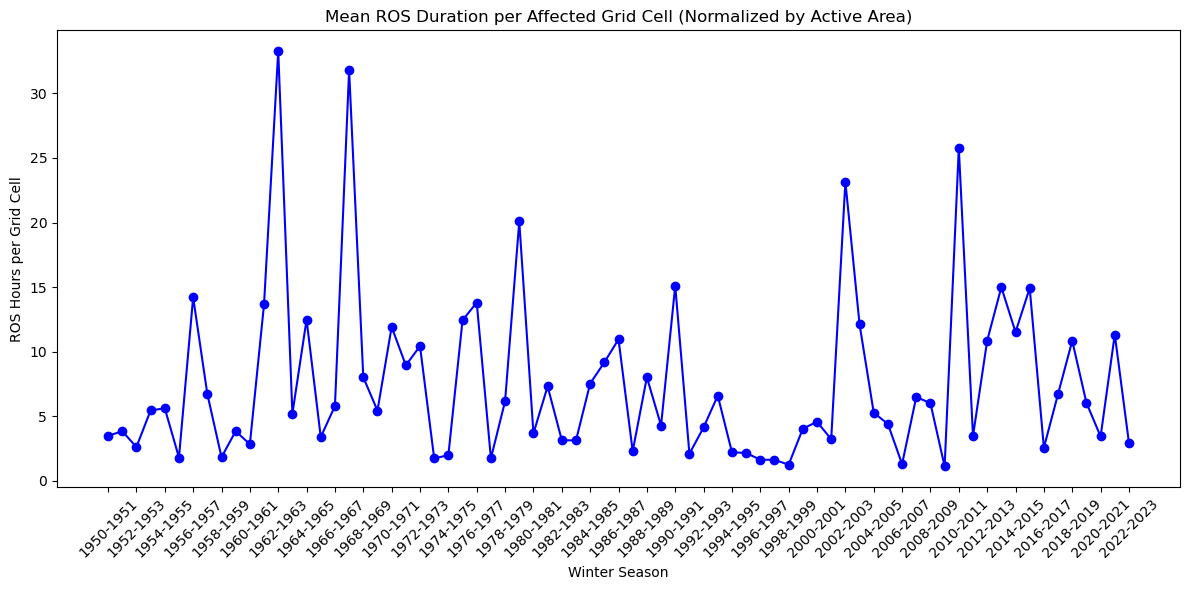

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue')
plt.title('Mean ROS Duration per Affected Grid Cell (Normalized by Active Area)')
#plt.title('Average Rain-on-Snow Duration per Grid Cell (Normalized by Area)')
plt.xlabel('Winter Season')
plt.ylabel('ROS Hours per Grid Cell')
plt.xticks(ticks=range(0, len(seasons), 2), labels=seasons[::2], rotation=45)
plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

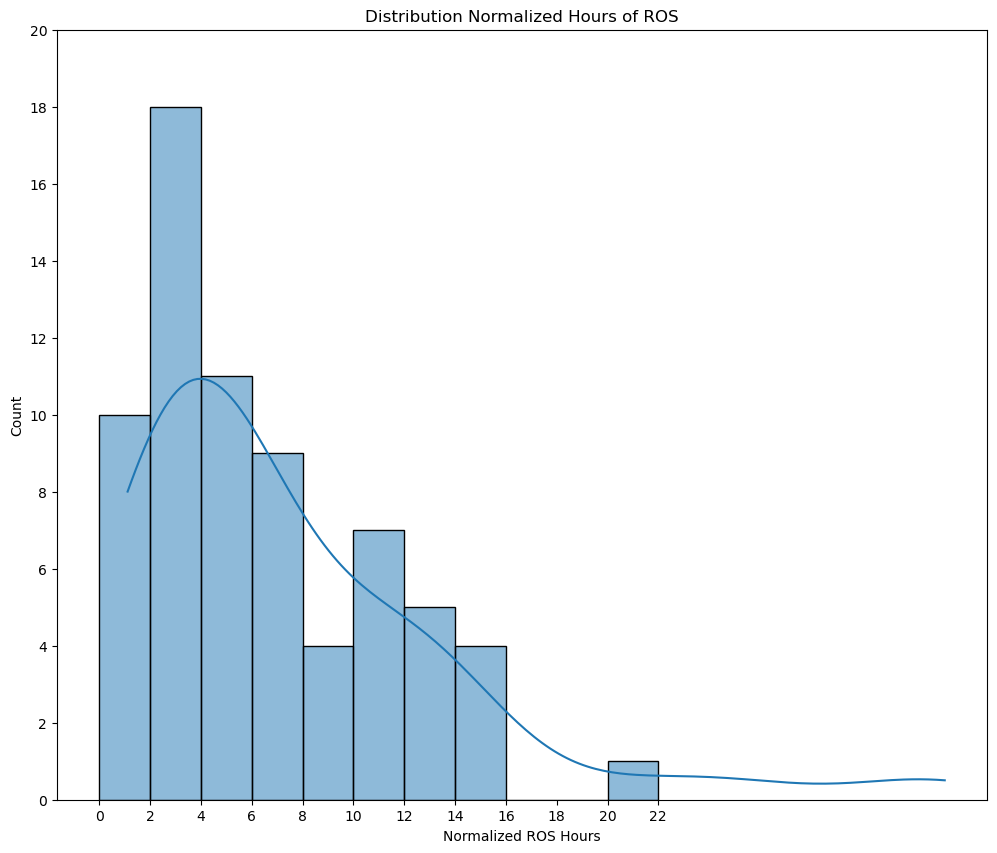

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
days_bins = np.arange(0, 24, 2)
sns.histplot(ros_hours_normalized, kde=True, ax=ax, bins=days_bins)
ax.set_title("Distribution Normalized Hours of ROS")
ax.set(xlabel='Normalized ROS Hours')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks(np.arange(0, 24,2))
ax.set_yticks(np.arange(0, 22,2))
fig.patch.set_alpha(0.0)
plt.show()

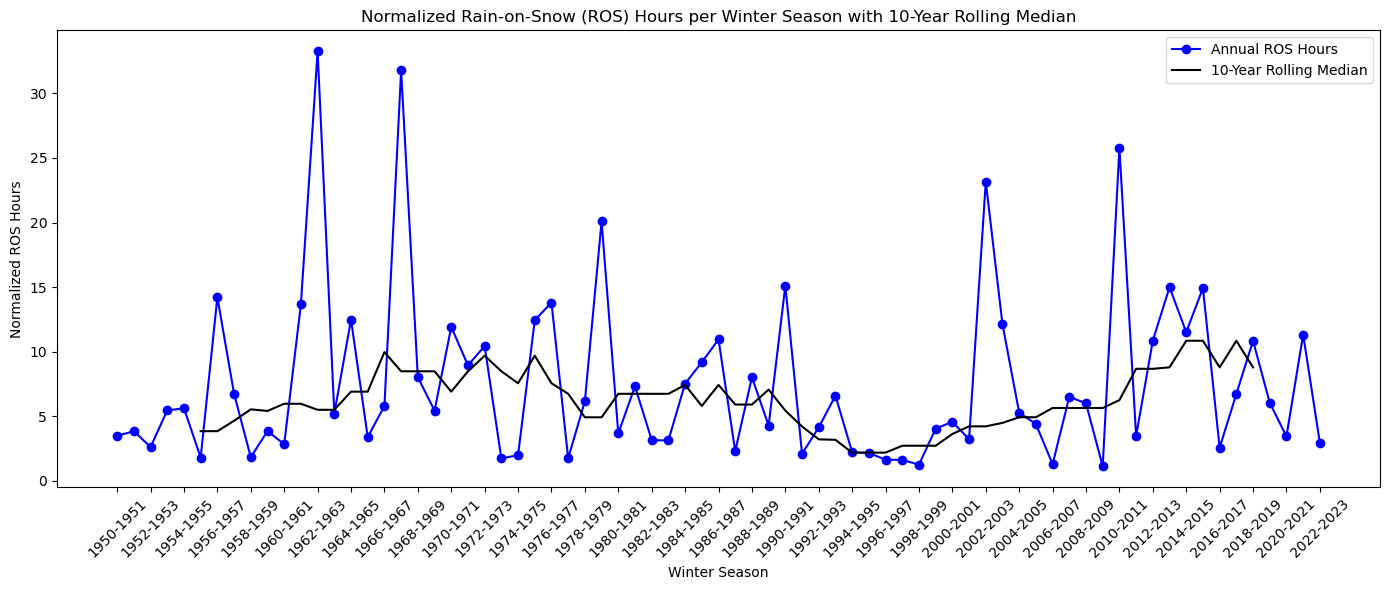

R² between ROS Hours and 10-Year Rolling Median: -0.876


In [18]:
df = pd.DataFrame({
    'season': seasons,
    'ros_hours': ros_hourly_totals_climatology,
    'normalized':ros_hours_normalized
})
normalized_rolling_10yr_hourly = df['normalized'].rolling(window=10, center=True).median()

plt.figure(figsize=(14, 6))
plt.plot(df['season'], df['normalized'], color='blue', marker='o', label='Annual ROS Hours')
plt.plot(df['season'], normalized_rolling_10yr_hourly, color='black', marker='', label='10-Year Rolling Median')

plt.xticks(ticks=range(0, len(df['season']), 2), labels=df['season'].iloc[::2], rotation=45)
#Total Rain-on-Snow (ROS) Hours per Winter Season with 10-Year Rolling Average
plt.title('Normalized Rain-on-Snow (ROS) Hours per Winter Season with 10-Year Rolling Median')
plt.xlabel('Winter Season')
plt.ylabel('Normalized ROS Hours')
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import r2_score

# Drop NaNs to align data properly
valid = ~normalized_rolling_10yr_hourly.isna()
r2 = r2_score(df['ros_hours'][valid], normalized_rolling_10yr_hourly[valid])
print(f'R² between ROS Hours and 10-Year Rolling Median: {r2:.3f}')

median=normalized_rolling_10yr_hourly.median()



NOW DOING PRECIPITATION 
-

In [19]:
path='/import/c1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ROS_Precip/'
pattern=f'ROS_P*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
data_precip = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

start_year = '1950-1951'
data_precip = data_precip.sel(season=data_precip.season >= start_year)
seasons=data['season']
average_ROS_tally=np.nanmean(data['ros_counts'],axis=0)
rain_ros_avg=data_precip['rain_ros_avg']

In [20]:
#The average amount of total rainfall
rain_sum_ROS_fnsb=[]
for i in range(len(data_precip['rain_ros_sum'].season)):
    avg=data_precip['rain_ros_sum'].isel(season=i).mean().compute().item()
    rain_sum_ROS_fnsb.append(avg)
print(rain_sum_ROS_fnsb)

rain_sum_fnsb=[]
for i in range(len(data_precip['rain_sum'].season)):
    avg=data_precip['rain_sum'].isel(season=i).mean().compute().item()
    rain_sum_fnsb.append(avg)
print(rain_sum_fnsb)

[0.003915431443601847, 0.00977920088917017, 0.004474786575883627, 0.006847456097602844, 0.011572318151593208, 0.0009232447482645512, 0.053750310093164444, 0.019271915778517723, 0.0007550655282102525, 0.0053793140687048435, 0.005389997735619545, 0.055722665041685104, 0.1502196043729782, 0.010897052474319935, 0.04176374152302742, 0.007910512387752533, 0.011869720183312893, 0.1262948215007782, 0.014978252351284027, 0.011579577811062336, 0.061059318482875824, 0.01539904996752739, 0.023829570040106773, 0.0004937267513014376, 0.0024832729250192642, 0.026259634643793106, 0.045900244265794754, 0.001219859579578042, 0.013457637280225754, 0.06747682392597198, 0.0075705102644860744, 0.020542452111840248, 0.00399052444845438, 0.00445165392011404, 0.016060050576925278, 0.027295920997858047, 0.03993642330169678, 0.003407127456739545, 0.04481247812509537, 0.007913381792604923, 0.049761246889829636, 0.003425653325393796, 0.007569297216832638, 0.015790963545441628, 0.002098025055602193, 0.0016896126326

In [21]:
#The average amount of total rainfall
avg_rain_ROS_fnsb=[]
for i in range(len(data_precip['rain_ros_avg'].season)):
    avg=data_precip['rain_ros_avg'].isel(season=i).mean().compute().item()
    avg_rain_ROS_fnsb.append(avg)
print(avg_rain_ROS_fnsb)

avg_rain_fnsb=[]
for i in range(len(data_precip['rain_avg'].season)):
    avg=data_precip['rain_avg'].isel(season=i).mean().compute().item()
    avg_rain_fnsb.append(avg)
print(avg_rain_fnsb)

[0.4097900986671448, 0.42207473516464233, 0.41307899355888367, 0.43991562724113464, 0.38518843054771423, 0.43262284994125366, 0.6399970054626465, 0.5023834705352783, 0.4981037676334381, 0.3812752664089203, 0.39125195145606995, 0.6645166277885437, 0.7503581047058105, 0.39685291051864624, 0.5503594875335693, 0.7812781929969788, 0.4500620365142822, 0.6512736678123474, 0.8023136258125305, 0.43310070037841797, 0.690879762172699, 0.4734903872013092, 0.8635808229446411, 0.3430001437664032, 0.3979414701461792, 0.5385980606079102, 0.5013882517814636, 0.3212769031524658, 0.4391865134239197, 0.5210394859313965, 0.3955764174461365, 0.4659538269042969, 0.3435336649417877, 0.37785741686820984, 0.4453984200954437, 0.4955579936504364, 0.5681009292602539, 0.46805551648139954, 0.9920938014984131, 0.39928075671195984, 0.5835185050964355, 0.4120473861694336, 0.35899657011032104, 0.43069881200790405, 0.37027180194854736, 0.31919047236442566, 0.3604947626590729, 0.3256229758262634, 0.2783678472042084, 0.499

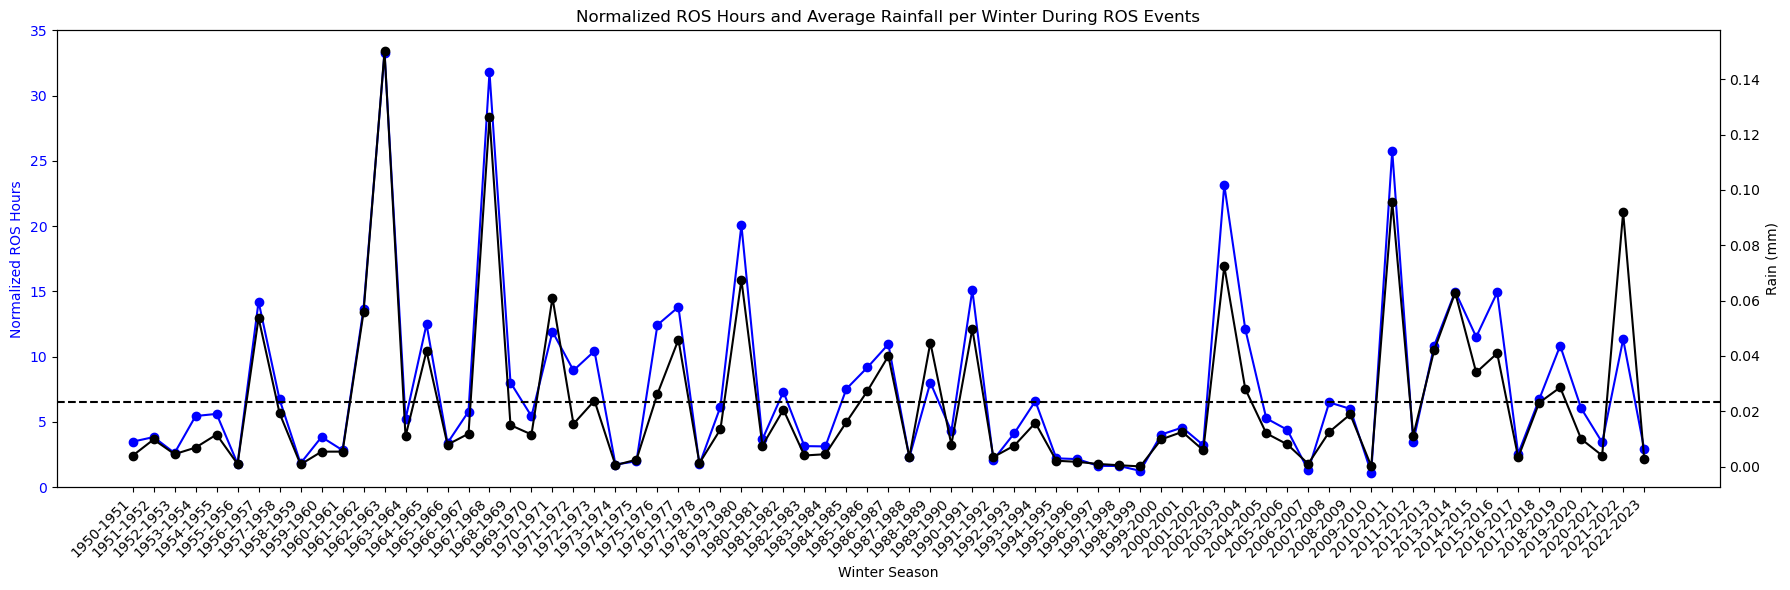

In [22]:
fig, ax1 = plt.subplots(figsize=(18, 6))
#ros_hours_normalized
ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, rain_sum_ROS_fnsb, marker='o', linestyle='-', color='black', label='')
plt.axhline(np.mean(rain_sum_ROS_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Rain (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
#plt.xticks(ticks=range(0, total_seasons, 2), labels=df['season'].iloc[::2], rotation=45)
plt.title('Normalized ROS Hours and Average Rainfall per Winter During ROS Events')
fig.tight_layout()
plt.show()

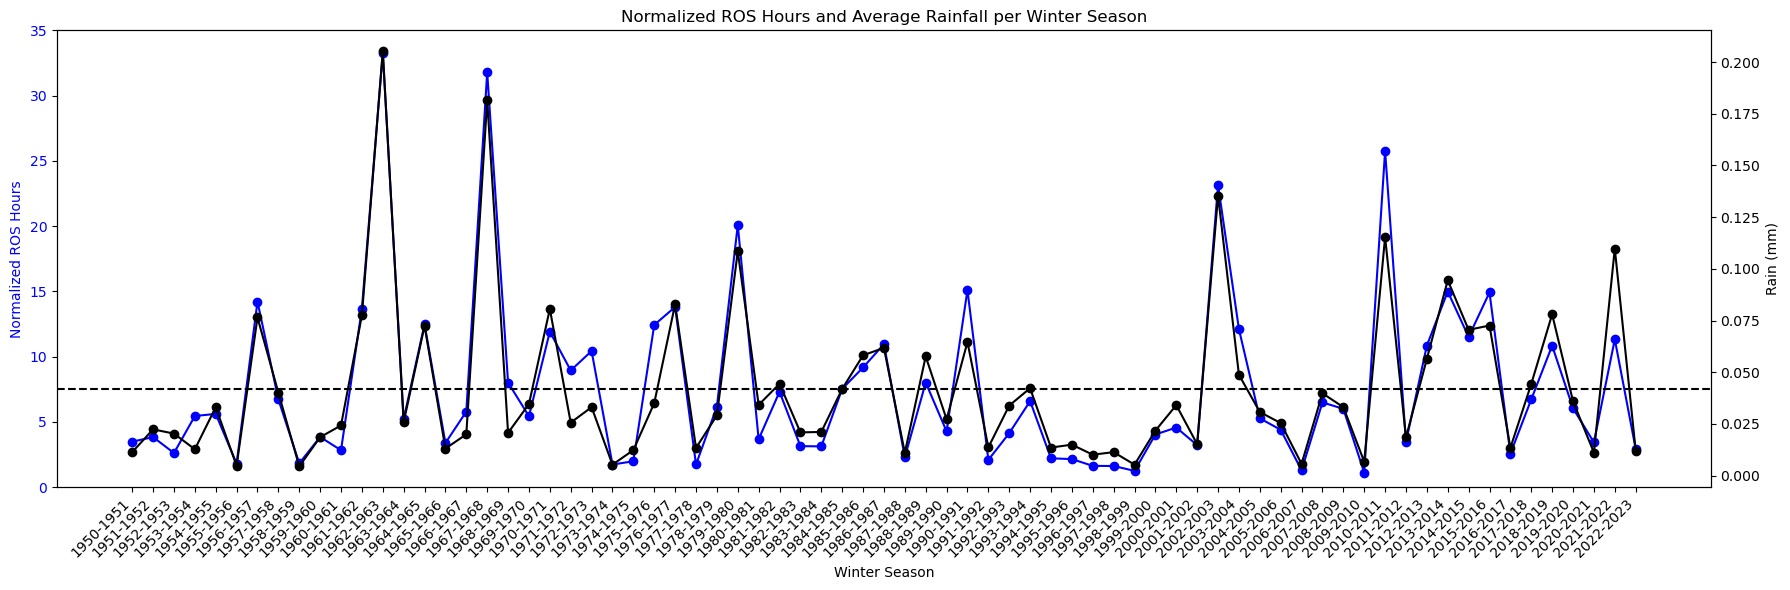

In [23]:
fig, ax1 = plt.subplots(figsize=(18, 6))
#ros_hours_normalized
ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, rain_sum_fnsb, marker='o', linestyle='-', color='black', label='')
plt.axhline(np.mean(rain_sum_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Rain (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
#plt.xticks(ticks=range(0, total_seasons, 2), labels=df['season'].iloc[::2], rotation=45)
plt.title('Normalized ROS Hours and Average Rainfall per Winter Season')
fig.tight_layout()
plt.show()

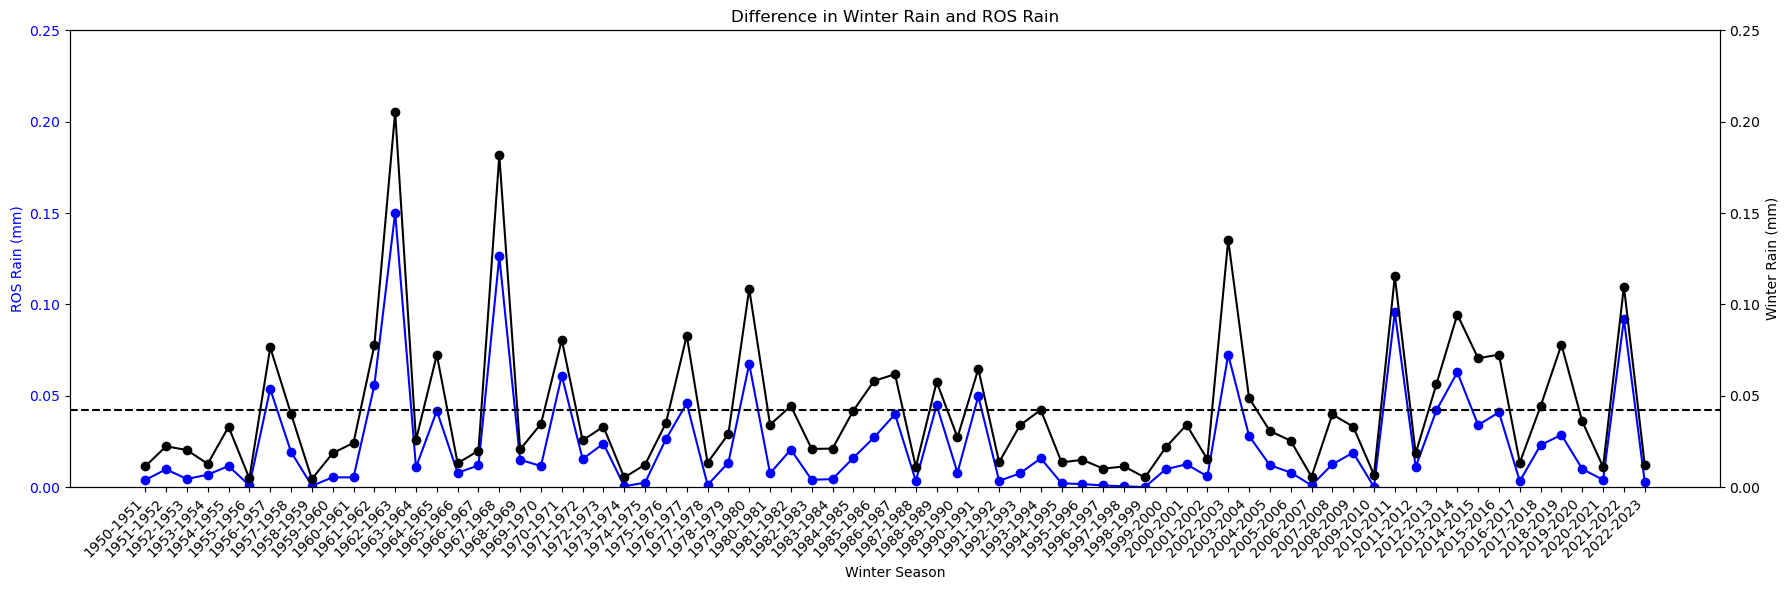

In [24]:
fig, ax1 = plt.subplots(figsize=(18, 6))
#ros_hours_normalized
ax1.plot(seasons, rain_sum_ROS_fnsb, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('ROS Rain (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0,0.25)
ax2 = ax1.twinx()

ax2.plot(seasons, rain_sum_fnsb, marker='o', linestyle='-', color='black', label='')
plt.axhline(np.mean(rain_sum_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Winter Rain (mm)', color='black')
ax2.set_ylim(0,0.25)
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.title('Difference in Winter Rain and ROS Rain')
fig.tight_layout()
plt.show()

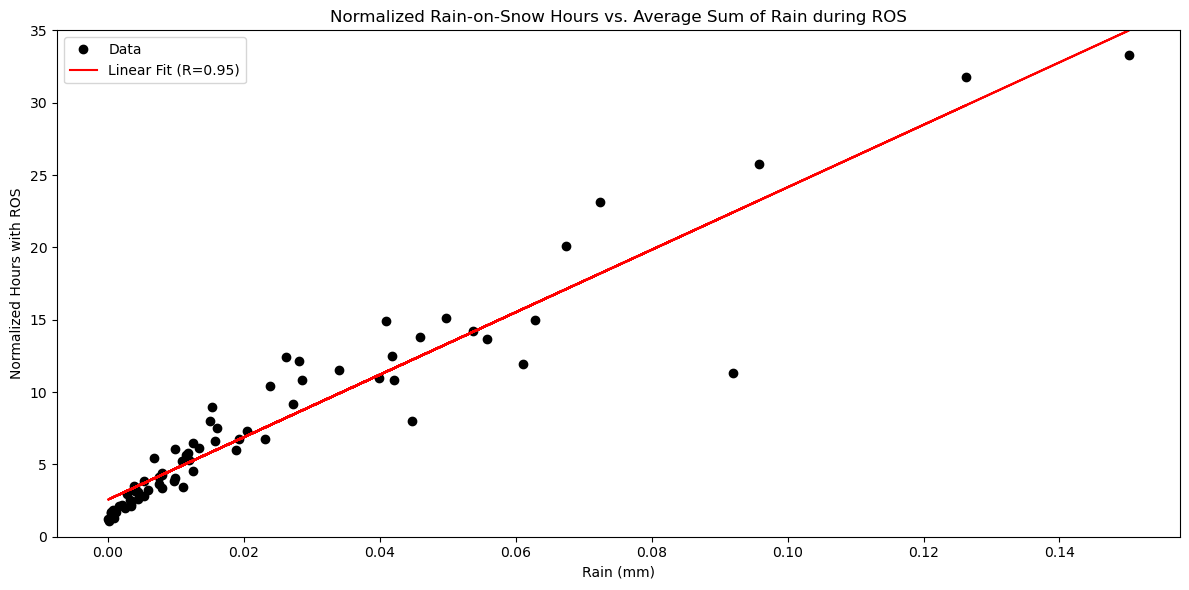

In [25]:
slope, intercept, r_value, p_value, std_err = linregress(rain_sum_ROS_fnsb, ros_hours_normalized)
x = np.array(rain_sum_ROS_fnsb)
y_fit = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS_fnsb, ros_hours_normalized, marker='o', linestyle='', color='black', label='Data')
plt.plot(x, y_fit, color='red', label=f'Linear Fit (R={r_value:.2f})')

plt.title('Normalized Rain-on-Snow Hours vs. Average Sum of Rain during ROS')
plt.xlabel('Rain (mm)')
plt.ylabel('Normalized Hours with ROS')
plt.legend()
plt.ylim(0,35)

plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.show()

RAIN_SUM IS THE SUM OF ALL THE RAIN DURING THE WINTER 
IF I TAKE THE AVERAGE OF THIS, THEN IT IS THE AVERAGE ACROSS THE WINTERS-- THE AVERAGE AMOUNT OF RAIN THAT FELL THAT WINTER. 
- 
RAIN_AVG IS THE AVERAGE HOURLY RAIN, 
IF I TAKE THE AVERAGE OF THIS, THEN IT IS THE AVERAGE HOURLY RATE ACROSS WINTERS
- 


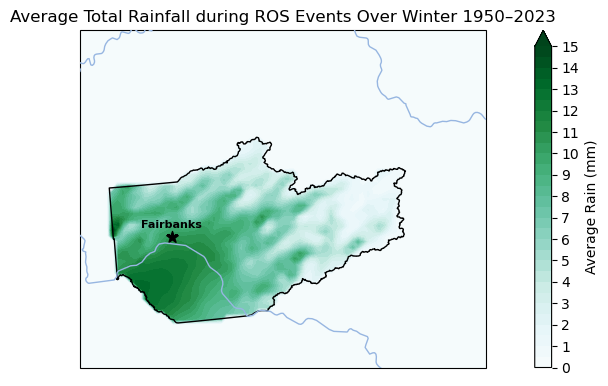

In [26]:
ros_sum_rain = np.mean(data_precip['rain_sum'],axis=0)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 15.5, 0.5) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_sum_rain, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Total Rainfall during ROS Events Over Winter 1950–2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

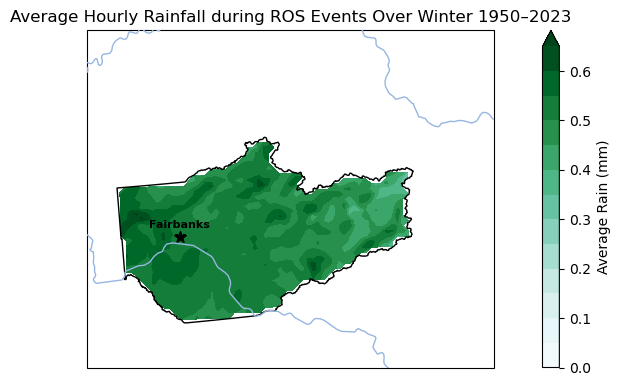

In [27]:
ros_avg_rain = np.mean(data_precip['rain_ros_avg'],axis=0)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_avg_rain, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall during ROS Events Over Winter 1950–2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

In [28]:
ros_rain_30_data = data_precip['rain_ros_avg']
last_10_years = 30
seasons_first_10 = seasons[last_10_years:]  
ros_trend_first_10 = ros_rain_30_data[last_10_years:, :, :] 
ros_trend_first_30= np.mean(ros_trend_first_10,axis=0)

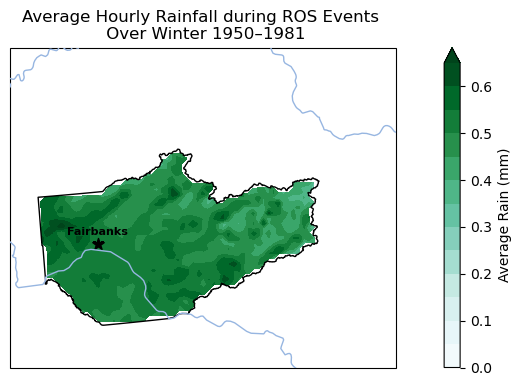

In [29]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_trend_first_30, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall during ROS Events \n Over Winter 1950–1981")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

In [30]:
ros_rain_30_data = data_precip['rain_ros_avg']
last_10_years = 30
seasons_last_10 = seasons[-last_10_years:]  
ros_trend_last_10 = ros_rain_30_data[-last_10_years:, :, :] 
ros_trend_last_30= np.mean(ros_trend_last_10,axis=0)


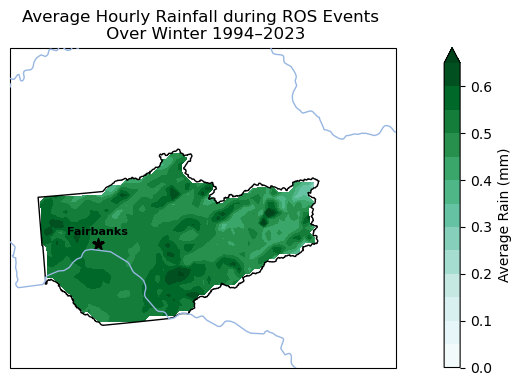

In [31]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('BuGn')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_trend_last_30, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall during ROS Events \n Over Winter 1994–2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

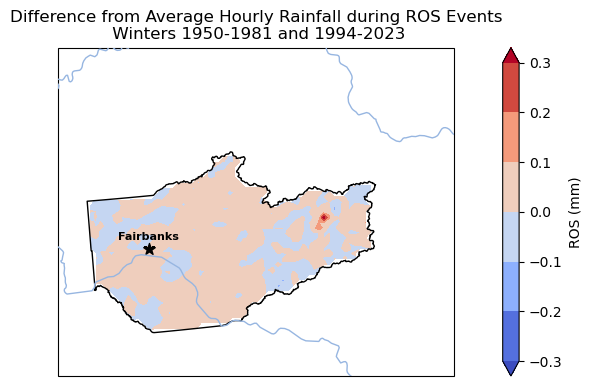

In [32]:
diff= ros_trend_last_30-ros_trend_first_30

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(-.3, 0.4,0.1)
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, diff, levels=levels, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS (mm)')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference from Average Hourly Rainfall during ROS Events\n Winters 1950-1981 and 1994-2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

TEMPERATURE PORTION
-

In [33]:
T2_avg_fnsb=[]
for i in range(len(data['T2_avg'].season)):
    avg=data['T2_avg'].isel(season=i).mean().compute().item()
    #avg = (avg - 273.15) * 9/5 + 32
    T2_avg_fnsb.append(avg)
print(T2_avg_fnsb)

T2_avg_ROS_fnsb=[]
for i in range(len(data['T2_ros_avg'].season)):
    avg=data['T2_ros_avg'].isel(season=i).mean().compute().item()
    #avg = (avg - 273.15) * 9/5 + 32
    T2_avg_ROS_fnsb.append(avg)
print(T2_avg_ROS_fnsb)

T2_avg_ROS_fnsb_C=np.array(T2_avg_ROS_fnsb)-273.15
T2_avg_fnsb_C=np.array(T2_avg_fnsb)-273.15

[253.6638946533203, 256.2445068359375, 258.71893310546875, 256.2822265625, 257.35760498046875, 252.78968811035156, 256.491943359375, 259.8514709472656, 255.8328399658203, 258.52606201171875, 258.4056091308594, 255.4522705078125, 259.1460876464844, 256.60601806640625, 255.94979858398438, 255.0322723388672, 255.7603302001953, 258.278076171875, 255.39747619628906, 260.37982177734375, 253.1292266845703, 253.0487518310547, 256.72576904296875, 254.90675354003906, 255.6294708251953, 255.15756225585938, 262.10626220703125, 258.4698791503906, 257.752197265625, 259.2404479980469, 261.215576171875, 256.3980712890625, 257.54888916015625, 258.83929443359375, 258.83319091796875, 259.5689392089844, 260.4145812988281, 260.30523681640625, 256.3272705078125, 255.6563262939453, 256.0351257324219, 257.611328125, 259.241943359375, 258.833984375, 256.27154541015625, 257.2996520996094, 256.60821533203125, 259.86328125, 255.9529266357422, 258.1968994140625, 262.60406494140625, 259.00823974609375, 262.36676025

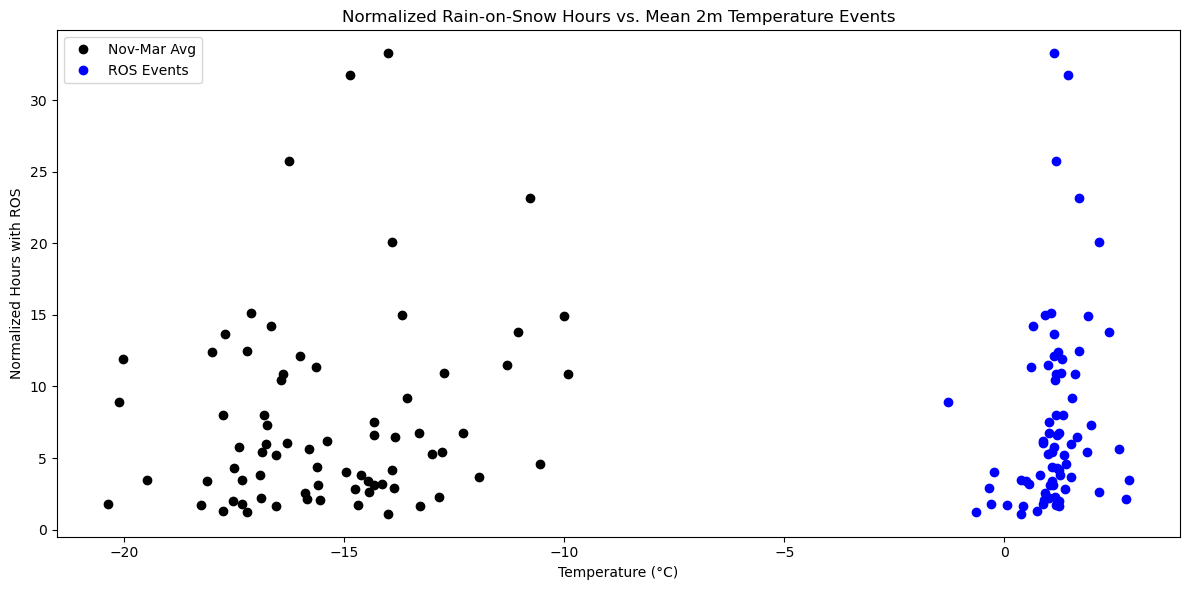

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(T2_avg_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='black',label='Nov-Mar Avg')
plt.plot(T2_avg_ROS_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='blue',label='ROS Events')
plt.title('Normalized Rain-on-Snow Hours vs. Mean 2m Temperature Events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized Hours with ROS')
plt.legend()

plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

Looking into Layers of the Atmosphere, 850,925,950,T2
-   

In [35]:
avg_temp_850=np.mean(data['temp_levels_avg'].sel(interp_level=850),axis=0)
avg_temp_925=np.mean(data['temp_levels_avg'].sel(interp_level=925),axis=0)
avg_temp_950=np.mean(data['temp_levels_avg'].sel(interp_level=950),axis=0)
avg_temp_850_C=avg_temp_850-273.15
avg_temp_925_C=avg_temp_925-273.15
avg_temp_950_C=avg_temp_950-273.15

avg_ros_temp_850=np.mean(data['temp_levels_ros_avg'].sel(interp_level=850),axis=0)
avg_ros_temp_925=np.mean(data['temp_levels_ros_avg'].sel(interp_level=925),axis=0)
avg_ros_temp_950=np.mean(data['temp_levels_ros_avg'].sel(interp_level=950),axis=0)
avg_ros_temp_850_C=avg_ros_temp_850-273.15
avg_ros_temp_925_C=avg_ros_temp_925-273.15
avg_ros_temp_950_C=avg_ros_temp_950-273.15

avg_ros_temp_T2=np.mean(data['T2_ros_avg'],axis=0)
avg_ros_temp_T2_C=avg_ros_temp_T2-273.15
avg_temp_T2=np.mean(data['T2_avg'],axis=0)
avg_temp_T2_C=avg_temp_T2-273.15

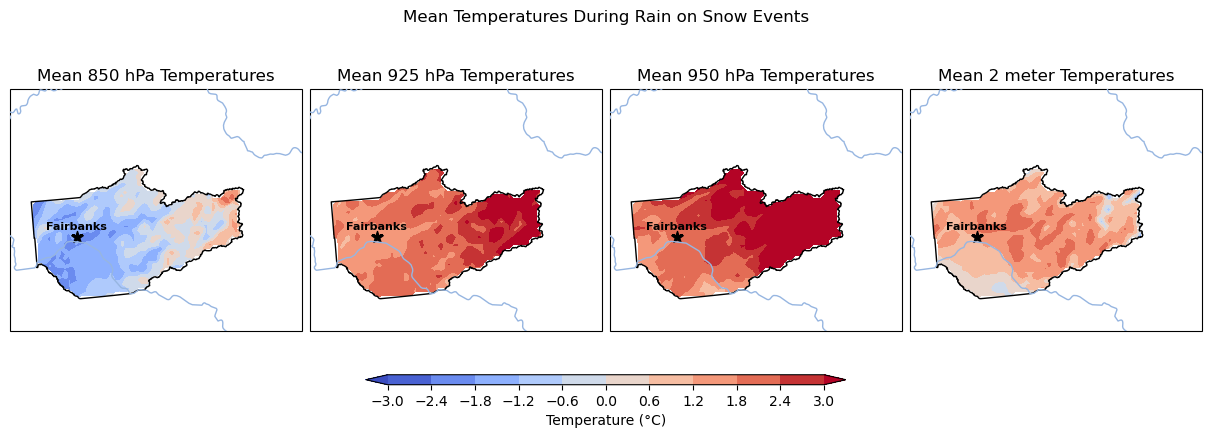

In [36]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65)
    )
}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

fig.suptitle("Mean Temperatures During Rain on Snow Events", y=0.9)

levels = np.linspace(-3, 3, 11)

cf1 = axs[0].contourf(lon, lat, avg_ros_temp_850_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[0].set_title("Mean 850 hPa Temperatures")

cf2 = axs[1].contourf(lon, lat, avg_ros_temp_925_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[1].set_title("Mean 925 hPa Temperatures")

cf3 = axs[2].contourf(lon, lat, avg_ros_temp_950_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[2].set_title("Mean 950 hPa Temperatures")

cf4 = axs[3].contourf(lon, lat, avg_ros_temp_T2_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[3].set_title("Mean 2 meter Temperatures")

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=5, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=9)
    ax.add_feature(cfeature.COASTLINE, zorder=9)
    ax.add_feature(cfeature.RIVERS, zorder=9)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf4, cax=cbar_ax, orientation='horizontal', label='Temperature (°C)', ticks=levels)

fig.patch.set_alpha(0.0)

plt.show()


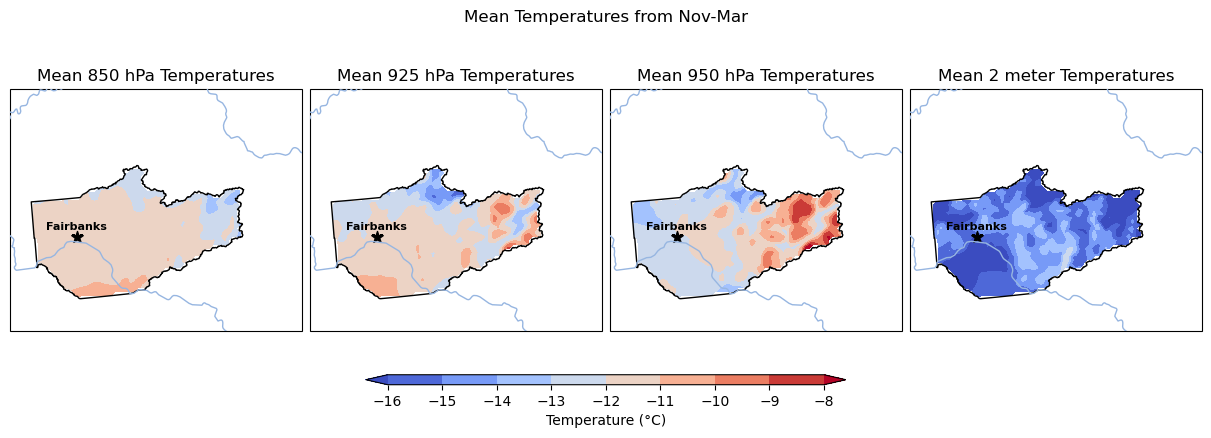

In [37]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65)
    )
}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

fig.suptitle("Mean Temperatures from Nov-Mar", y=0.9)

levels = np.linspace(-16, -8, 9)

cf1 = axs[0].contourf(lon, lat, avg_temp_850_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[0].set_title("Mean 850 hPa Temperatures")

cf2 = axs[1].contourf(lon, lat, avg_temp_925_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[1].set_title("Mean 925 hPa Temperatures")

cf3 = axs[2].contourf(lon, lat, avg_temp_950_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[2].set_title("Mean 950 hPa Temperatures")

cf4 = axs[3].contourf(lon, lat, avg_temp_T2_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[3].set_title("Mean 2 meter Temperatures")

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=5, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=9)
    ax.add_feature(cfeature.COASTLINE, zorder=9)
    ax.add_feature(cfeature.RIVERS, zorder=9)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf4, cax=cbar_ax, orientation='horizontal', label='Temperature (°C)', ticks=levels)

fig.patch.set_alpha(0.0)

plt.show()

In [38]:
avg_ros_temp_850_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=850).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_850_C_FNSB.append(avg_C)
print(avg_ros_temp_850_C_FNSB)

avg_ros_temp_925_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=925).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_925_C_FNSB.append(avg_C)
print(avg_ros_temp_925_C_FNSB)

avg_ros_temp_950_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=950).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_950_C_FNSB.append(avg_C)
print(avg_ros_temp_950_C_FNSB)




[1.1452575683593977, 2.1644836425781477, -0.40515747070310226, -3.3746704101562273, -0.12091674804685226, -2.6453918457031023, -1.6750854492187273, -1.5804199218749773, -4.530706787109352, -0.8362487792968523, 0.04589233398439774, 0.17977294921877274, -0.8351196289062273, 0.29839477539064774, -0.9098571777343523, -3.9077514648437273, -3.6908020019531023, -1.0001586914062273, -3.4911560058593523, -2.1763366699218523, -0.17389526367185226, -1.2243103027343523, -3.4832824707031023, -7.546667480468727, -3.9362243652343523, -2.3635925292968523, 1.0136657714843977, -1.4965576171874773, -3.1126770019531023, -0.38846435546872726, 0.24276123046877274, 2.0918212890625227, -2.4246887207031023, -0.37988891601560226, -1.8355773925781023, -0.14407958984372726, 0.6267333984375227, -1.6908630371093523, -1.4596618652343523, -1.5250915527343523, -2.8114990234374773, -1.3546203613281023, -1.5592102050781023, -1.9712280273437273, -1.9143737792968523, 1.9439636230468977, -3.8349670410156023, 0.093896484375

[1.7110229492187727, 2.2700744628906477, 2.8024536132812727, 0.49270019531252274, 4.034814453125023, 1.8131347656250227, 0.9554992675781477, 2.1505065917968977, 0.11217651367189774, 2.0992675781250227, 2.5128112792968977, 3.0474487304687727, 2.0866943359375227, 3.1219116210937727, 2.3953796386718977, 0.08419189453127274, 0.7720886230468977, 2.4088073730468977, 0.03792724609377274, 1.4382873535156477, 2.7097412109375227, 0.8008056640625227, 0.05785522460939774, -3.2696899414062273, 0.08895263671877274, 1.5699707031250227, 3.9782043457031477, 0.31456909179689774, 0.6185546875000227, 3.0326782226562727, 2.4858947753906477, 4.444177246093773, 1.7831359863281477, 2.6647888183593977, 1.1942993164062727, 2.6887756347656477, 2.7823120117187727, 1.3679138183593977, 2.1299072265625227, 2.0528503417968977, 0.6917968750000227, 2.0977722167968977, 1.8924804687500227, 1.8095642089843977, 1.4895263671875227, 4.206811523437523, 0.26915893554689774, 3.0159545898437727, 2.3456970214843977, 1.84777221679

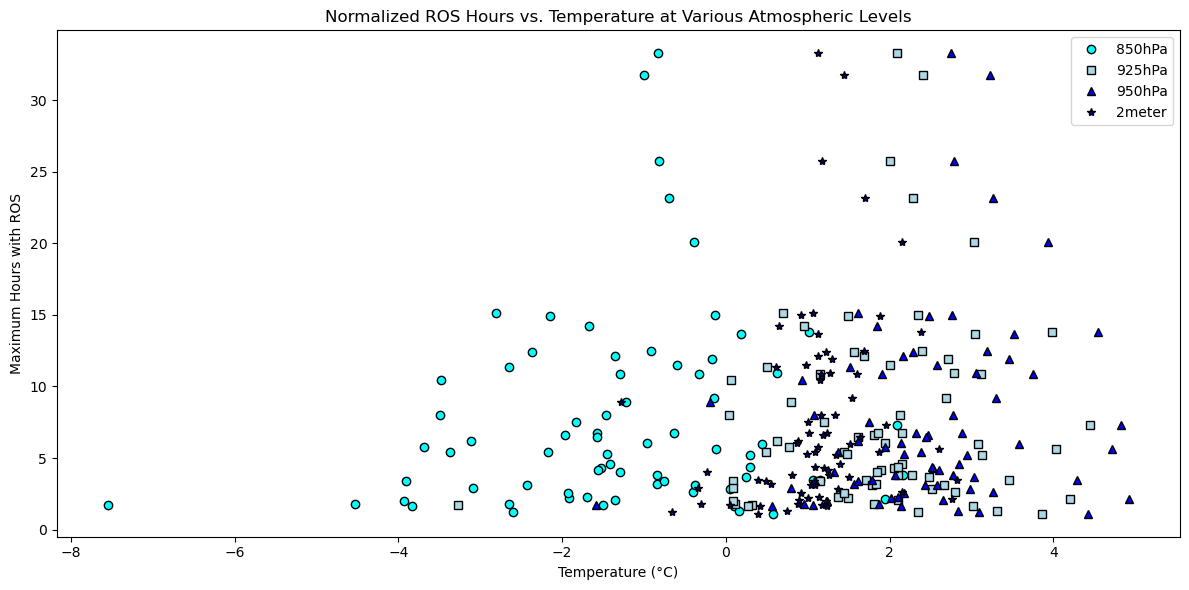

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(avg_ros_temp_850_C_FNSB, ros_hours_normalized, marker='o', linestyle='',markeredgecolor='black', color='aqua',label='850hPa')
plt.plot(avg_ros_temp_925_C_FNSB, ros_hours_normalized, marker='s', linestyle='', markeredgecolor='black',color='lightblue',label='925hPa')
plt.plot(avg_ros_temp_950_C_FNSB, ros_hours_normalized, marker='^', linestyle='', markeredgecolor='black',color='blue',label='950hPa')
plt.plot(T2_avg_ROS_fnsb_C, ros_hours_normalized, marker='*', linestyle='', markeredgecolor='black', color='darkblue',label='2meter')
plt.title('Normalized ROS Hours vs. Temperature at Various Atmospheric Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.legend()
plt.tight_layout()
plt.show()

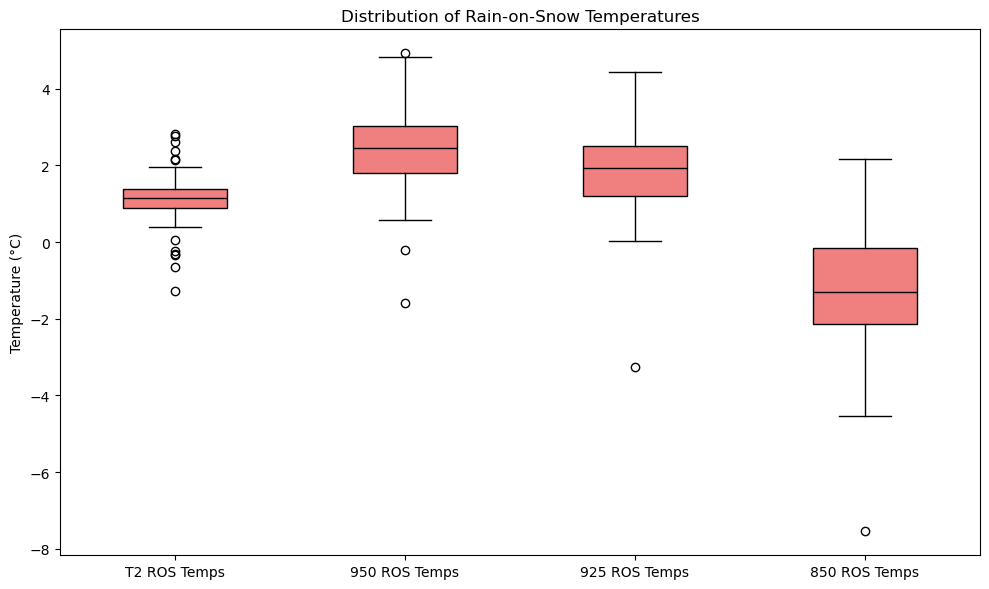

In [40]:
import matplotlib.pyplot as plt

# Data to plot
data = [
    T2_avg_ROS_fnsb_C,
    avg_ros_temp_950_C_FNSB,
    avg_ros_temp_925_C_FNSB,
    avg_ros_temp_850_C_FNSB
]

labels = [
    'T2 ROS Temps',
    '950 ROS Temps',
    '925 ROS Temps',
    '850 ROS Temps'
]

colors = ['lightcoral', 'lightcoral', 'lightcoral', 'lightcoral']

fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(data, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax.set_title('Distribution of Rain-on-Snow Temperatures')
ax.set_ylabel('Temperature (°C)')
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
fig.patch.set_alpha(0.0)
plt.grid(axis='y', linestyle='', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
path='/import/c1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ROS_Tlevels/'
pattern=f'ROS_Tl*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

avg_temp_850_s=np.mean(data['temp_levels_avg'].sel(interp_level=850),axis=(1,2))
avg_temp_925_s=np.mean(data['temp_levels_avg'].sel(interp_level=925),axis=(1,2))
avg_temp_950_s=np.mean(data['temp_levels_avg'].sel(interp_level=950),axis=(1,2))
avg_temp_850_C_s=avg_temp_850_s-273.15
avg_temp_925_C_s=avg_temp_925_s-273.15
avg_temp_950_C_s=avg_temp_950_s-273.15

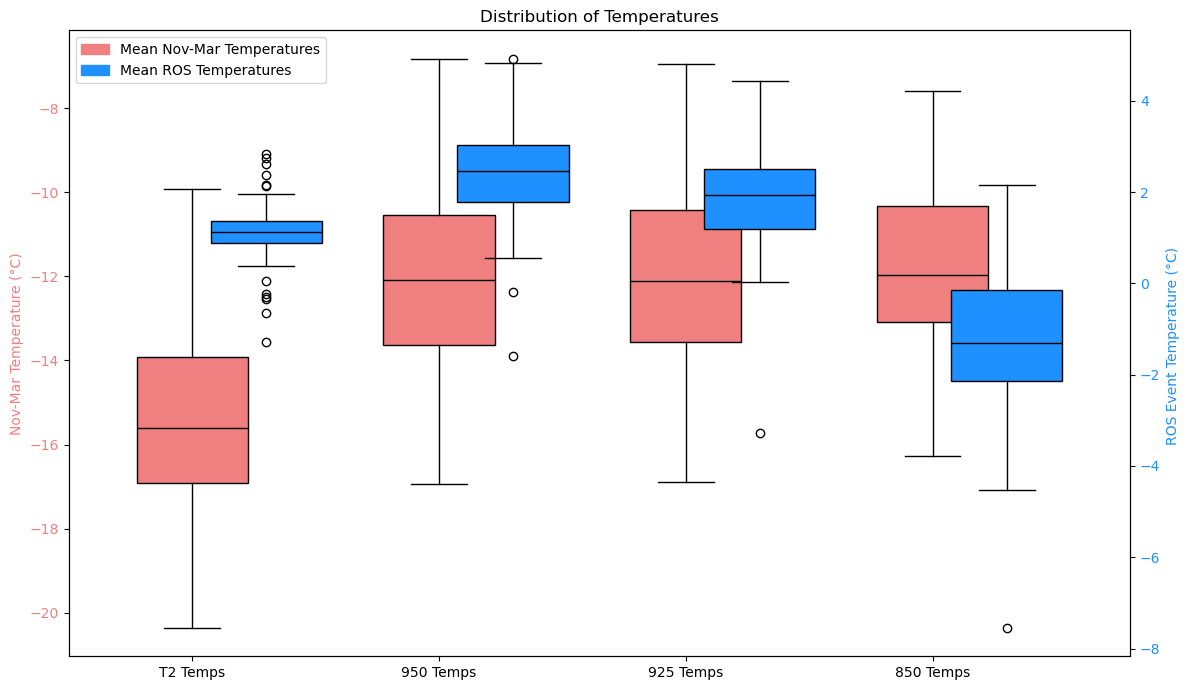

In [42]:
data1 = [
    T2_avg_fnsb_C,
    avg_temp_950_C_s,
    avg_temp_925_C_s,
    avg_temp_850_C_s
]
labels1 = ['T2 Temps', '950 Temps', '925 Temps', '850 Temps']

data2 = [
    T2_avg_ROS_fnsb_C,
    avg_ros_temp_950_C_FNSB,
    avg_ros_temp_925_C_FNSB,
    avg_ros_temp_850_C_FNSB
]
labels2 = ['T2 ROS Temps', '950 ROS Temps', '925 ROS Temps', '850 ROS Temps']

colors1 = ['lightcoral'] * 4
colors2 = ['dodgerblue'] * 4

fig, ax1 = plt.subplots(figsize=(12, 7))


box1 = ax1.boxplot(data1, positions=range(1, len(data1) + 1), patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(box1['boxes'], colors1):
    patch.set_facecolor(color)

ax1.set_ylabel('Nov-Mar Temperature (°C)', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')
ax1.set_xticks(range(1, len(labels1) + 1))
ax1.set_xticklabels(labels1)
ax1.set_title('Distribution of Temperatures')
ax2 = ax1.twinx()


positions2 = [x + 0.3 for x in range(1, len(data2) + 1)]

box2 = ax2.boxplot(data2, positions=positions2, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(box2['boxes'], colors2):
    patch.set_facecolor(color)
ax2.set_ylabel('ROS Event Temperature (°C) ', color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

ax1.grid(axis='y', linestyle='', alpha=0.5)
ax1.set_xticks(range(1, len(labels1) + 1))
ax1.set_xticklabels(labels1)
proxy1 = mpatches.Patch(color='lightcoral', label='Mean Nov-Mar Temperatures')
proxy2 = mpatches.Patch(color='dodgerblue', label='Mean ROS Temperatures')
ax1.legend(handles=[proxy1, proxy2], loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
def period_mask_analysis(data, seasons, start_year, end_year):
    season_strings = seasons.values.astype(str)
    season_start_years = np.array([int(season.split('-')[0]) for season in season_strings])
    mask = (season_start_years >= start_year) & (season_start_years <= end_year)
    data_filtered = data.isel(season=np.where(mask)[0])
    return data_filtered

def seasonal_avg_data(data, variable):
    avg = np.mean(data[variable], axis=0)
    return avg


PERIOD ANALYSIS

In [ ]:
dataT=data
dataP=data_precip
dataT_1950_1974=period_mask_analysis(dataT,seasons,1950,1974)
dataT_1975_1999=period_mask_analysis(dataT,seasons,1975,1999)

dataP_1950_1974=period_mask_analysis(dataP,seasons,1950,1974)
dataP_1975_1999=period_mask_analysis(dataP,seasons,1975,1999)

In [45]:
ros_tally_1950_1974=seasonal_avg_data(dataT_1950_1974,'ros_tally')
ros_tally_1975_1999=seasonal_avg_data(dataT_1975_1999,'ros_tally')

ros_days_count_1950_1974=seasonal_avg_data(dataT_1950_1974,'ros_days_count')
ros_days_count_1975_1999=seasonal_avg_data(dataT_1975_1999,'ros_days_count')

ros_hourly_rainfall_1950_1974=seasonal_avg_data(dataP_1950_1974,'rain_ros_avg')
ros_hourly_rainfall_1975_1999=seasonal_avg_data(dataP_1975_1999,'rain_ros_avg')

ros_avgsum_rainfall_1950_1974=seasonal_avg_data(dataP_1950_1974,'rain_ros_sum')
ros_avgsum_rainfall_1975_1999=seasonal_avg_data(dataP_1975_1999,'rain_ros_sum')
